We fist create a python wrapper to access the `nh` tool included in the ftools. A running [installation of HEASoft](https://heasarc.nasa.gov/lheasoft/) is needed.

In [1]:
import subprocess

def nhf(coords, nhmap='LAB'):
    if nhmap == 'DL':
        umap = 1        
    elif nhmap == 'LAB':
        umap = 0        
    else:
        raise ValueError('Unknown map: {}'.format(nhmap))
        
    ra = coords.icrs.ra.deg
    dec = coords.icrs.dec.deg
    equinox = 2000.0

    command = 'nh {} {} {} usemap={}'.format(equinox, ra, dec, umap)
    log = subprocess.check_output(command, shell=True)

    for line in log.splitlines():
        if '{} >> Weighted'.format(nhmap) in str(line):
            nhval = line.split()[-1]

        if 'Try with a distance larger' in str(line):
            nhval = -1

    return float(nhval)

A quick test for our `nhf` function:

In [2]:
from astropy.coordinates import SkyCoord

coords = SkyCoord(ra=136.0, dec=44.0, unit='deg')
nh_ftools = nhf(coords)
print(nh_ftools)

1.63e+20


We generate *n* random lines-of-sight in the sky and calculate the corresponding Galactic nh (LAB map) using three methods:

In [3]:
import numpy as np
from gdpyc import GasMap

n = 5000
rand_ra_deg = 360*np.random.random(size=n)
rand_dec_deg = 180*np.random.random(size=n) - 90.0
rand_coords = SkyCoord(ra=rand_ra_deg, dec=rand_dec_deg, unit='deg')

# Bilinear interpolation of HEALpix map (~1 deg resolution):
nh_gdpyc_nh = GasMap.nh(rand_coords)
print(nh_gdpyc_nh)

# gdpyc implementation of HEASoft's nh: 
# fits map of 0.675 deg resolution and distance 
# weighted average of all pixels within 1 deg circle
nh_gdpyc_nhf = GasMap.nhf(rand_coords)       
print(nh_gdpyc_nhf)

# Values from HEASoft's nh 
nh_ftools = np.array([nhf(c) for c in rand_coords])
print(nh_ftools)


[1.01918835e+22 1.00612002e+21 8.72479816e+20 ... 3.52866945e+20
 6.96608279e+20 3.13010689e+20] 1 / cm2


/home/alnoah/miniconda2/envs/astroenvpy3/lib/python3.6/site-packages/astropy/coordinates/angles.py:651: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home/alnoah/miniconda2/envs/astroenvpy3/lib/python3.6/site-packages/astropy/coordinates/angles.py:651: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home/alnoah/miniconda2/envs/astroenvpy3/lib/python3.6/site-packages/astropy/coordinates/angles.py:534: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home/alnoah/miniconda2/envs/astroenvpy3/lib/python3.6/site-packages/astropy/coordinates/angles.py:534: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


weights sum is zero!!
<SkyCoord (ICRS): (ra, dec) in deg
    (186.92943751, 30.34607018)>


/home/alnoah/miniconda2/envs/astroenvpy3/lib/python3.6/site-packages/gdpyc-1.0-py3.6.egg/gdpyc/core.py:304: RuntimeWarning: invalid value encountered in true_divide


[1.06900533e+22 1.02986324e+21 8.76849618e+20 ... 3.60777040e+20
 6.82826189e+20 2.94444406e+20] 1 / cm2
[1.07e+22 1.03e+21 8.75e+20 ... 3.61e+20 6.83e+20 2.94e+20]


We can compare the results of the two gdpyc methods with those of ftools:

/home/alnoah/miniconda2/envs/astroenvpy3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/alnoah/miniconda2/envs/astroenvpy3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in greater
/home/alnoah/miniconda2/envs/astroenvpy3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater
/home/alnoah/miniconda2/envs/astroenvpy3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/alnoah/miniconda2/envs/astroenvpy3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


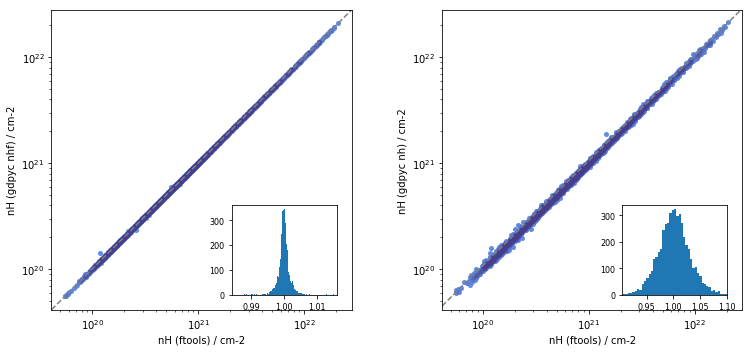

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = plt.figure(figsize=(11,5))

# nh_ftools vs nh_gdpyc_nhf
ax = plt.subplot(121, aspect='equal')
plt.loglog(nh_ftools, nh_gdpyc_nhf, marker='o',
           markerfacecolor='CornflowerBlue', markeredgecolor='None',
           markersize=5, linestyle='None')
plt.loglog(nh_ftools, nh_gdpyc_nhf, marker='o', alpha=0.1,
           markerfacecolor='DarkSlateBlue', markeredgecolor='None',
           markersize=5, linestyle='None')
# This plot is done twice, the latter with transparency, to get
# a quick visual impresion of the density of points:
# darker colours, higher the density

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
plt.plot([xmin, xmax], [ymin, ymax], linestyle='--', color='gray')

plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.xlabel('nH (ftools) / cm-2')
plt.ylabel('nH (gdpyc nhf) / cm-2')

# We add an inset plot with the distribution 
# of nh ratios (gdpyc/ftools values)
ratio = nh_gdpyc_nhf.value/nh_ftools
ratio_mean = ratio[ratio > 0].mean()
ratio_std = ratio[ratio > 0].std()

iax = inset_axes(ax, width="35%", height="30%", loc=4, borderpad=1.5)
iax.hist(ratio[ratio > 0], bins='auto')
iax.tick_params('both', labelsize=8)
iax.set_xlim(ratio_mean - 3*ratio_std, ratio_mean + 3*ratio_std)


# nh_ftools vs nh_gdpyc_nh
ax = plt.subplot(122, aspect='equal')
plt.loglog(nh_ftools, nh_gdpyc_nh, marker='o',
           markerfacecolor='CornflowerBlue', markeredgecolor='None',
           markersize=5, linestyle='None')
plt.loglog(nh_ftools, nh_gdpyc_nh, marker='o', alpha=0.1,
           markerfacecolor='DarkSlateBlue', markeredgecolor='None',
           markersize=5, linestyle='None')

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
plt.plot([xmin, xmax], [ymin, ymax], linestyle='--', color='gray')

plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.xlabel('nH (ftools) / cm-2')
plt.ylabel('nH (gdpyc nh) / cm-2')

# We add an inset plot with the distribution 
# of nh ratios (gdpyc/ftools values)
ratio = nh_gdpyc_nh.value/nh_ftools
ratio_mean = ratio[ratio > 0].mean()
ratio_std = ratio[ratio > 0].std()

iax = inset_axes(ax, width="35%", height="30%", loc=4, borderpad=1.5)
iax.hist(ratio[ratio > 0], bins='auto')
iax.tick_params('both', labelsize=8)
iax.set_xlim(ratio_mean - 3*ratio_std, ratio_mean + 3*ratio_std)

plt.tight_layout()
plt.savefig('images/nh_ftools_vs_gdpyc.png')

We also want to compare the results in the whole sky. To this end we first create a grid of points:

In [17]:
nlon, nlat = 361, 181   # 361, 181 for one deg distance
lon = np.linspace(-np.pi, np.pi, num=nlon)
lat = np.linspace(-np.pi/2., np.pi/2., num=nlat)
grid_lon, grid_lat = np.meshgrid(lon, lat)
coords = SkyCoord(l=grid_lon, b=grid_lat, unit='rad', frame='galactic')
print(coords.shape)

(181, 361)


Now we estimate the corresponding nh values for the grid points:

In [18]:
nh2_gdpyc_nhf = GasMap.nhf(coords)
nh2_gdpyc_nh = GasMap.nh(coords)

nrows, ncols = coords.shape
nh2_ftools = [[nhf(coords[i,j]) for j in range(ncols)]
             for i in range(nrows)]

ratio_nhf = nh2_gdpyc_nhf.value/nh2_ftools
rmin_nhf = ratio_nhf[ratio_nhf > 0].min()
rmax_nhf = ratio_nhf[ratio_nhf > 0].max()
print(rmin_nhf, rmax_nhf, np.median(ratio_nhf[ratio_nhf > 0]))

ratio_nh = nh2_gdpyc_nh.value/nh2_ftools
rmin_nh = ratio_nh[ratio_nh > 0].min()
rmax_nh = ratio_nh[ratio_nh > 0].max()
print(rmin_nh, rmax_nh, np.median(ratio_nh[ratio_nh > 0]))


/home/alnoah/miniconda2/envs/astroenvpy3/lib/python3.6/site-packages/astropy/coordinates/angles.py:651: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home/alnoah/miniconda2/envs/astroenvpy3/lib/python3.6/site-packages/astropy/coordinates/angles.py:651: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home/alnoah/miniconda2/envs/astroenvpy3/lib/python3.6/site-packages/astropy/coordinates/angles.py:534: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home/alnoah/miniconda2/envs/astroenvpy3/lib/python3.6/site-packages/astropy/coordinates/angles.py:534: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home/alnoah/miniconda2/envs/astroenvpy3/lib/python3.6/site-packages/gdpyc-1.0

weights sum is zero!!
<SkyCoord (Galactic): (l, b) in deg
    (180., -84.)>
weights sum is zero!!
<SkyCoord (Galactic): (l, b) in deg
    (181., -84.)>
weights sum is zero!!
<SkyCoord (Galactic): (l, b) in deg
    (182., -84.)>
weights sum is zero!!
<SkyCoord (Galactic): (l, b) in deg
    (183., -84.)>
weights sum is zero!!
<SkyCoord (Galactic): (l, b) in deg
    (184., -84.)>
weights sum is zero!!
<SkyCoord (Galactic): (l, b) in deg
    (185., -84.)>
weights sum is zero!!
<SkyCoord (Galactic): (l, b) in deg
    (175., -84.)>
weights sum is zero!!
<SkyCoord (Galactic): (l, b) in deg
    (176., -84.)>
weights sum is zero!!
<SkyCoord (Galactic): (l, b) in deg
    (177., -84.)>
weights sum is zero!!
<SkyCoord (Galactic): (l, b) in deg
    (178., -84.)>
weights sum is zero!!
<SkyCoord (Galactic): (l, b) in deg
    (179., -84.)>
weights sum is zero!!
<SkyCoord (Galactic): (l, b) in deg
    (180., -84.)>
weights sum is zero!!
<SkyCoord (Galactic): (l, b) in deg
    (180., -83.)>
weights sum 

/home/alnoah/miniconda2/envs/astroenvpy3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/home/alnoah/miniconda2/envs/astroenvpy3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/alnoah/miniconda2/envs/astroenvpy3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


Finally, we plot the ratio of the two methods in an all-sky map, using a mollweide projection:

/home/alnoah/miniconda2/envs/astroenvpy3/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


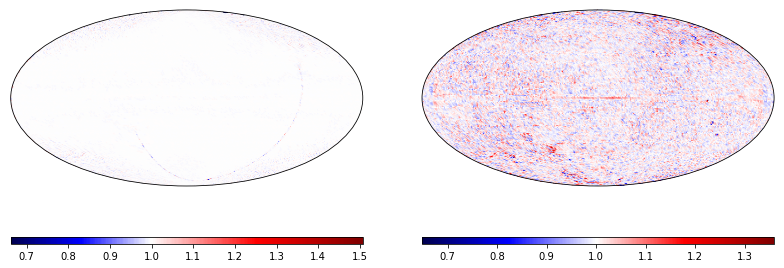

In [20]:
import matplotlib.colors as colors

# This class allows selecting a particular value as the middle point of the colour scale
# From: https://matplotlib.org/gallery/userdemo/colormap_normalizations_custom.html
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

    
fig = plt.figure(figsize=(11,5))
ax = fig.add_subplot(121, projection="mollweide")
im = ax.pcolormesh(grid_lon, grid_lat, ratio_nhf, cmap=plt.cm.seismic,
                   norm=MidpointNormalize(midpoint=1.), 
                   vmin=rmin_nhf, antialiased=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.colorbar(im, ax=ax, orientation='horizontal', aspect=50)


ax = fig.add_subplot(122, projection="mollweide")
im = ax.pcolormesh(grid_lon, grid_lat, ratio_nh, cmap=plt.cm.seismic,
                   norm=MidpointNormalize(midpoint=1.), 
                   vmin=rmin_nh, antialiased=True)
ax.set_xticklabels([])
ax.set_yticklabels([])

fig.colorbar(im, ax=ax, orientation='horizontal', aspect=50)

plt.tight_layout(w_pad=5)
plt.savefig('images/ratios_LAB_lowres.png')